In [1]:
import pandas as pd
import numpy as np
import pathlib
import os
import shutil

from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    mean_pinball_loss,
)

from utils_experiment import (
    load_data,
    get_model_list,
    plot_forecasts_analysis,
    rmse,
    pinball_loss,
    average_pinball_loss,
    plot_quantile_forecast
)

# General data loading for all experiments 

In [2]:
exp_test_description = "Full_Report"
directory = f"/h/kupfersk/cfpr_2025/generate_forecasts/output/"

report_sim_dates = open("experiment_cutoff_dates.txt", 'r').read().split()
# report_sim_dates = report_sim_dates[:-1]

# report_sim_dates= [report_sim_dates[-1]]

target_categories = [
    'Bakery and cereal products (excluding baby food)',
     'Dairy products and eggs',
     'Fish, seafood and other marine products',
     'Food purchased from restaurants',
     'Food',
     'Fruit, fruit preparations and nuts',
     'Meat',
     'Other food products and non-alcoholic beverages',
     'Vegetables and vegetable preparations'
]


target_categories = [f"food_cpi: {col}" for col in target_categories]

start_years = [1986]
random_seed = 42

print("Target Categories:\n" + '\n'.join(target_categories))
print("Report Simulation Dates:\n" + '\n'.join(report_sim_dates))



file_path = "../data/processed_data/all_data_processed.csv"
all_data, foodprice_df, target_categories, all_covariates = load_data(target_categories, file_path)

Target Categories:
food_cpi: Bakery and cereal products (excluding baby food)
food_cpi: Dairy products and eggs
food_cpi: Fish, seafood and other marine products
food_cpi: Food purchased from restaurants
food_cpi: Food
food_cpi: Fruit, fruit preparations and nuts
food_cpi: Meat
food_cpi: Other food products and non-alcoholic beverages
food_cpi: Vegetables and vegetable preparations
Report Simulation Dates:
2018-07-01
2019-07-01
2020-07-01
2021-07-01
2022-07-01
2023-07-01


In [3]:
EXP_BASE_LIST = ["ag_local", "ag_global_cpi", "ag_global_with_covariates"]

ignore_list = [".csv",
               "ipynb",
                "llama",
#                 "gemini",
#                 "claude",
#                 "gpt",
               "GPT_P",
#                "human",
               "_R",
               "Mixtral",
               '5th',
               "restaurants",
               "DeepARModel_exp",
               "ChronosModel_exp",
               "PatchTSTModel_exp",
               "DLinearModel_exp",
               "exp7",
               "exp8",
               "corr",
               "economic",
#                "report",

               

               
               
]

experiments = []
# for experiment_name in os.listdir(f"{directory}{exp_test_description}"):
#     if 'ipynb' not in experiment_name:
#         if '.csv' not in experiment_name:
#             if "ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp" not in experiment_name:
#                 if "llama" not in experiment_name:
#                     if "gemini" not in experiment_name:
#                         if "claude" not in experiment_name:
#                             if "gpt" not in experiment_name:



#                 experiments.append(experiment_name)

for experiment_name in os.listdir(f"{directory}{exp_test_description}"):
    if all(keyword not in experiment_name for keyword in ignore_list):
        experiments.append(experiment_name)


        # # Read the file and store the content in a list
        # llm_directory = '/h/kupfersk/cfpr_llm/Results_percentiles/Raw_data/'

        # with open((llm_directory + 'llm_models.txt'), 'r') as file:
        #     # Read all lines and strip any extra whitespace/newline characters
        #     loaded_list = [line.strip() for line in file]


        # experiments = experiments + loaded_list
experiments

['ag_local_DeepARModel',
 'ag_global_all_TemporalFusionTransformerModel_exp1_human_',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel',
 'gemini-1.5-pro_report_True_with_future_forecasts_True',
 'ag_global_all_SimpleFeedForwardModel_exp1_human_',
 'ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_',
 'ag_local_AutoETSModel',
 'gemini-1.5-pro_report_False_with_future_forecasts_True',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_human_',
 'claude-3-5-sonnet-20240620_report_True_with_future_forecasts_True',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_',
 'ag_global_all_PatchTSTModel',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_',
 'gemini-1.5-pro_report_True',
 'gpt-4o_report_True',
 'ag_global_all_TemporalFusionTransfo

### Ensure all necessary data is stored in Experimental_Analysis folder for easy access 

### Define evaluation metrics and calculate mape for all periods

In [4]:
point_metrics = {
    "r2_score": r2_score,
    "mae": mean_absolute_error,
    "mape": mean_absolute_percentage_error,
    "mse": mean_squared_error,
    "rmse": rmse,
}

In [5]:
experiments

['ag_local_DeepARModel',
 'ag_global_all_TemporalFusionTransformerModel_exp1_human_',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel',
 'gemini-1.5-pro_report_True_with_future_forecasts_True',
 'ag_global_all_SimpleFeedForwardModel_exp1_human_',
 'ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_',
 'ag_local_AutoETSModel',
 'gemini-1.5-pro_report_False_with_future_forecasts_True',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_human_',
 'claude-3-5-sonnet-20240620_report_True_with_future_forecasts_True',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_',
 'ag_global_all_PatchTSTModel',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_',
 'gemini-1.5-pro_report_True',
 'gpt-4o_report_True',
 'ag_global_all_TemporalFusionTransfo

In [6]:
import json


def compute_all_scores(report_sim_dates, study_metric="mape"):
    global forecast_df
    global actual_df
    global predicted_categories
    
    results = []
    
        
    # Load the dictionary from the JSON file
    with open('../generate_forecasts/target_category_dict_filt.json', 'r') as json_file:
        target_category_dict = json.load(json_file)
        
    for start_year in start_years:



        for EXPERIMENT_NAME in experiments:
            predicted_categories = []
            
            print(EXPERIMENT_NAME)
            if 'ag' in EXPERIMENT_NAME :
                predicted_categories = target_categories
#                 if "R" not in EXPERIMENT_NAME:
#                     if 'exp' in EXPERIMENT_NAME: 
#                         general_experiment = f"exp{EXPERIMENT_NAME.split('_exp')[-1]}"
                        
#                         predicted_categories_in = target_category_dict[general_experiment]
                    
                    # Drop items containing the word 'restaurant' or exactly 'food_cpi: Food'
#                     predicted_categories = [item for item in predicted_categories_in if 'restaurant' not in item.lower() and item != 'food_cpi: Food']
#                 else:
#                     predicted_categories = target_categories
                
            else:
                predicted_categories = [
                                        'food_cpi: Bakery and cereal products (excluding baby food)',
                                         'food_cpi: Meat',
                                         'food_cpi: Vegetables and vegetable preparations'
                                    ]

            for category in predicted_categories:
                if "restaurant" in category:
                    continue 
                    
                scores = []

                for cutoff_date in report_sim_dates:

                    forecast_csv_path = f"../generate_forecasts/output/{exp_test_description}/{EXPERIMENT_NAME}/random_seed_{random_seed}/{cutoff_date}/forecasts/{category}.csv"
                    forecast_df = pd.read_csv(forecast_csv_path, index_col=0)
                    forecast_df.index = pd.to_datetime(forecast_df.index)

                    actual_df = foodprice_df[category].loc[
                        [
                            date
                            for date in forecast_df.index
                            if date in foodprice_df.index
                        ]
                    ]
                    
                    if report_sim_dates[-1] == cutoff_date:
                        forecast_df = forecast_df.iloc[:-1]
                        actual_df = actual_df.iloc[:-1]


                    if study_metric in point_metrics:
                        median_col = "q_0.5"
                        y_pred = forecast_df[median_col]
                        y_true = actual_df
                        if len(y_pred) > len(y_true):
                            y_pred = y_pred[: len(y_true)]
                        scores.append(
                            point_metrics[study_metric](y_true=y_true, y_pred=y_pred)
                        )

                    elif study_metric == "pinball_loss":
                        y_pred = forecast_df
                        y_true = actual_df
                        if len(y_pred) > len(y_true):
                            y_pred = y_pred[: len(y_true)]
                        scores.append(
                            average_pinball_loss(
                                y_true=y_true,
                                y_pred_quantiles=y_pred,
                                quantiles=[
                                    0.01,
                                    0.05,
                                    0.1,
                                    0.25,
                                    0.75,
                                    0.9,
                                    0.95,
                                    0.99,
                                ],
                            )
                        )

                mean_score = np.mean(scores)
                std_score = np.std(scores)

                results.append(
                    {   "year": start_year,
                        "experiment": EXPERIMENT_NAME,
                        "category": category,
                        "mean_score": mean_score,
                        "std_score": std_score,
                        "scores": scores
                    }
                )

    return pd.DataFrame(results)



In [7]:
with open('../generate_forecasts/target_category_dict_filt.json', 'r') as json_file:
    target_category_dict = json.load(json_file)
    
target_category_dict

{'exp5_geopolitical_': ['food_cpi: Bakery and cereal products (excluding baby food)',
  'food_cpi: Dairy products and eggs',
  'food_cpi: Fish, seafood and other marine products',
  'food_cpi: Food purchased from restaurants',
  'food_cpi: Food',
  'food_cpi: Fruit, fruit preparations and nuts',
  'food_cpi: Meat',
  'food_cpi: Other food products and non-alcoholic beverages',
  'food_cpi: Vegetables and vegetable preparations'],
 'exp5_manufacturing_': ['food_cpi: Bakery and cereal products (excluding baby food)',
  'food_cpi: Dairy products and eggs',
  'food_cpi: Fish, seafood and other marine products',
  'food_cpi: Food purchased from restaurants',
  'food_cpi: Food',
  'food_cpi: Fruit, fruit preparations and nuts',
  'food_cpi: Meat',
  'food_cpi: Other food products and non-alcoholic beverages',
  'food_cpi: Vegetables and vegetable preparations'],
 'exp5_climate_': ['food_cpi: Bakery and cereal products (excluding baby food)',
  'food_cpi: Dairy products and eggs',
  'food_cpi

In [8]:
## For classical model experiments 

mape_df = compute_all_scores(report_sim_dates, "mape")
mape_df

mape_df['path']= "f'./output/{exp_test_description}/{EXPERIMENT_NAME}/random_seed_42/{cutoff_date}/forecasts/{category}.csv'"

mape_df

ag_local_DeepARModel
ag_global_all_TemporalFusionTransformerModel_exp1_human_
ag_global_cpi_with_covariates_TemporalFusionTransformerModel
gemini-1.5-pro_report_True_with_future_forecasts_True
ag_global_all_SimpleFeedForwardModel_exp1_human_
ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_
ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_
ag_local_AutoETSModel
gemini-1.5-pro_report_False_with_future_forecasts_True
ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_
ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_human_
claude-3-5-sonnet-20240620_report_True_with_future_forecasts_True
ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_
ag_global_all_PatchTSTModel
ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_
gemini-1.5-pro_report_True
gpt-4o_report_True
ag_global_all_TemporalFusionTransformerModel
ag_local_SimpleFeedForwardModel
gemini-1.5-pro_report_False


,year,experiment,category,mean_score,std_score,scores,path
0,1986,ag_local_DeepARModel,food_cpi: Bakery and cereal products (excludin...,0.036713,0.021999,"[0.011036732060852398, 0.019971501010228897, 0...",f'./output/{exp_test_description}/{EXPERIMENT_...
1,1986,ag_local_DeepARModel,food_cpi: Dairy products and eggs,0.032611,0.016330,"[0.019867074994984066, 0.027847746093486305, 0...",f'./output/{exp_test_description}/{EXPERIMENT_...
2,1986,ag_local_DeepARModel,"food_cpi: Fish, seafood and other marine products",0.022050,0.015371,"[0.010854690989193488, 0.011447317441345844, 0...",f'./output/{exp_test_description}/{EXPERIMENT_...
3,1986,ag_local_DeepARModel,food_cpi: Food,0.033385,0.021728,"[0.01192819864460277, 0.015630026544120393, 0....",f'./output/{exp_test_description}/{EXPERIMENT_...
4,1986,ag_local_DeepARModel,"food_cpi: Fruit, fruit preparations and nuts",0.038141,0.017945,"[0.02813726903135804, 0.02401235303421688, 0.0...",f'./output/{exp_test_description}/{EXPERIMENT_...
...,...,...,...,...,...,...,...
279,1986,ag_local_TemporalFusionTransformerModel,food_cpi: Food,0.032911,0.020694,"[0.013975713709548246, 0.01231863941864048, 0....",f'./output/{exp_test_description}/{EXPERIMENT_...
280,1986,ag_local_TemporalFusionTransformerModel,"food_cpi: Fruit, fruit preparations and nuts",0.046375,0.022073,"[0.02169973008505353, 0.03503221154346888, 0.0...",f'./output/{exp_test_description}/{EXPERIMENT_...
281,1986,ag_local_TemporalFusionTransformerModel,food_cpi: Meat,0.031168,0.010951,"[0.016441312292381497, 0.04095060925211494, 0....",f'./output/{exp_test_description}/{EXPERIMENT_...
282,1986,ag_local_TemporalFusionTransformerModel,food_cpi: Other food products and non-alcoholi...,0.031610,0.021170,"[0.012615555976243205, 0.011859104984157813, 0...",f'./output/{exp_test_description}/{EXPERIMENT_...


# Figure 1. Sensitivity analysis by regressor theme sorted by food category

Steps:
1) load in all data
2) Do this for TemporalFusionTransformer
3) Repeat for global all and global+covariates 


In [9]:
# Define the function to assign condition based on keywords in experiment names
def assign_condition(experiment):
    experiment = experiment.lower()  # Make lowercase for case-insensitive matching
    if 'climate' in experiment:
        return 'Exogenous (climate)'
    
    elif '_exp2' in experiment:
        return 'Exogenous (random)' 
    
    elif 'manufacturing' in experiment:
        return 'Exogenous (manufacturing)'
    
    elif 'geopolitical' in experiment:
        return 'Exogenous (geopolitical)'
    
    elif 'exp1_llm' in experiment:
        return 'Exogenous (LLM)'
    
    elif 'exp1_human' in experiment:
        return 'Exogenous (human)'
    
    elif 'local' in experiment:
        return 'Baseline - None'
    
    elif 'cpi' in experiment and 'geopolitical' not in experiment and 'climate' not in experiment and 'llm' not in experiment and 'human' not in experiment:
        return 'Exogenous (CPI)'
    
    # Check for both 'future_forecasts' and 'report_True'
    elif '_future_forecasts_true' in experiment and '_report_true' in experiment:
        return 'Multi: Future forecasts + CFPR + Exogenous (human)'
    
    # Check only for 'future_forecasts'
    elif '_future_forecasts_true' in experiment and '_report_false' in experiment:
        return 'Multi: Future forecasts + Exogenous (human)'
    
    # Check for LLM models (Chronos in this case)
    elif 'prices' in experiment:
        return 'Baseline - None'

    # Check for general deep learning models
    elif 'exo_shifted' in experiment:
        return 'Exogenous (human)'
    
    # Check for statistical models
    elif '_report_true' in experiment:
        return 'Multi: CFPR + Exogenous (human)'

    elif '_report_false' in experiment:
        return 'Exogenous (human)'
    

       
    elif 'global_all' in experiment:
        return 'Baseline - Exogenous (All)'
    
    # Add default return to catch unmatched cases
    else: 
        return 'Unmatched'
    
#     else: 
#         return 'None'

# Apply the function to add a new column 'condition' in filt_df

filt_df = mape_df.reset_index()
filt_df['condition'] = filt_df['experiment'].apply(assign_condition)

# Display the full DataFrame with the new 'condition' column
filt_df['condition'].unique()
# filt_df.iloc[33].experiment

array(['Baseline - None', 'Exogenous (human)', 'Exogenous (CPI)',
       'Multi: Future forecasts + CFPR + Exogenous (human)',
       'Exogenous (geopolitical)', 'Exogenous (LLM)',
       'Multi: Future forecasts + Exogenous (human)',
       'Exogenous (climate)', 'Baseline - Exogenous (All)',
       'Exogenous (manufacturing)', 'Multi: CFPR + Exogenous (human)'],
      dtype=object)

In [10]:
# filt_df = filt_df.loc[filt_df['experiment'].str.contains('Transformer', na=False)]


In [11]:
filt_df.loc[filt_df['category'] == 'food_cpi: Dairy products and eggs'].experiment

1                                   ag_local_DeepARModel
9      ag_global_all_TemporalFusionTransformerModel_e...
17     ag_global_cpi_with_covariates_TemporalFusionTr...
28      ag_global_all_SimpleFeedForwardModel_exp1_human_
36     ag_global_all_SimpleFeedForwardModel_exp5_geop...
44     ag_global_cpi_with_covariates_TemporalFusionTr...
52                                 ag_local_AutoETSModel
63     ag_global_cpi_with_covariates_TemporalFusionTr...
71     ag_global_cpi_with_covariates_TemporalFusionTr...
82     ag_global_cpi_with_covariates_TemporalFusionTr...
90                           ag_global_all_PatchTSTModel
98     ag_global_cpi_with_covariates_TemporalFusionTr...
112         ag_global_all_TemporalFusionTransformerModel
120                      ag_local_SimpleFeedForwardModel
131                                ag_local_ChronosModel
139                 ag_global_all_SimpleFeedForwardModel
147                            ag_global_all_DeepARModel
155    ag_global_all_TemporalFu

In [12]:
# #Define regressor themes 
# regressor_theme = ['geopolitical', 'economic', 'climate', 'manufacturing', 'llm']
# # regressor_theme = [regressor_theme[0]]
# regressor_theme
# print (f"Themes being evaluated are {regressor_theme}")


# #Define models to be included
# train_methods = ['ag_local',
#               'ag_global_all',
#               'ag_global_cpi_with_covariates'
#               ]

# model_names = [
#  'TemporalFusionTransformerModel',
#     'SimpleFeedForwardModel'
#               ]

# find_model = []
# for train_method in train_methods:
#     for model_name in model_names:
#         find_model.append(f"{train_method}_{model_name}")
        
# pattern = "|".join(find_model)
        
# #Find all models that include these base models
# filt_df = mape_df[mape_df['experiment'].str.contains(pattern, case=False, na=False)]
# filt_df.experiment.unique()


In [13]:
filt_df.sort_values(by='condition', inplace=True)
filt_df['model_name'] = filt_df['experiment'].apply(lambda x: 'TemporalFusionTransformer' if 'transformer' in x.lower() else ('SimpleFeedForward' if 'simple' in x.lower() else None))


/tmp/ipykernel_20805/629432406.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


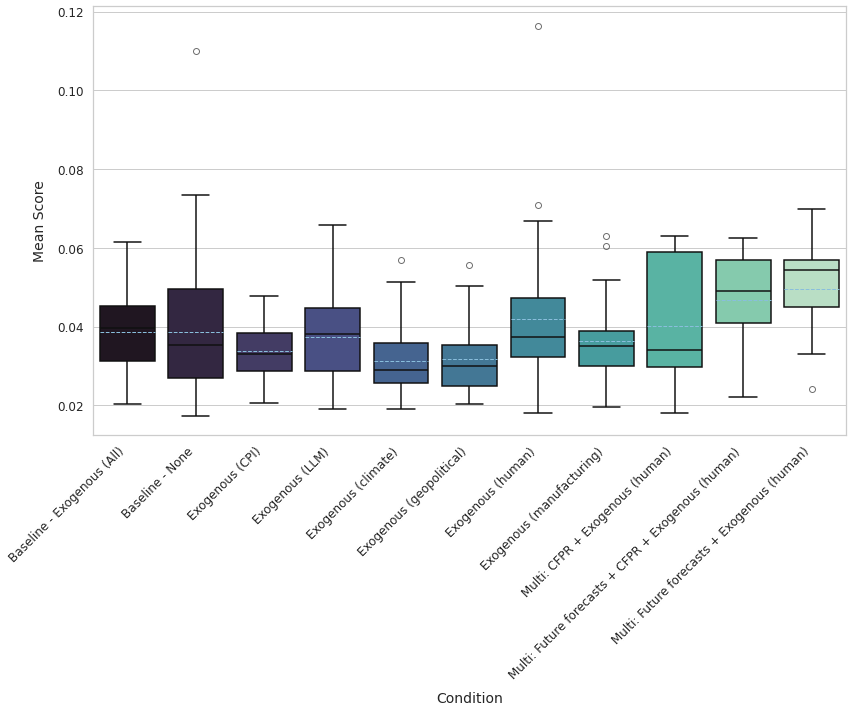

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
# Set Seaborn style
sns.set_theme(style="whitegrid", palette="Blues")

palette = sns.color_palette("mako", n_colors=filt_df['condition'].nunique())


# Create a boxplot with customized settings
plt.figure(figsize=(12, 10))
sns.boxplot(
    data=filt_df, 
    x='condition', 
    y='mean_score', 
    showmeans=True, 
    meanline=True, 
    linewidth=1.5,
    flierprops={'marker': 'o', 'color': 'lightblue', 'alpha': 0.6},
    palette=palette  # Apply the customized color palette
)

# Customize fonts and angles with adjustments for proper alignment
# plt.title("Distribution of mean scores for different context inclusion - Averaged across all food categories and model types", fontsize=18, pad=20)
plt.xlabel("Condition", fontsize=14, labelpad=10)
plt.ylabel("Mean Score", fontsize=14, labelpad=10)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)

# Adjust layout for better alignment and appearance
plt.tight_layout()
plt.savefig('./Fig71.pdf', bbox_inches='tight')

plt.show()

In [15]:
summary_pivot = filt_df.groupby('model_name').agg(
    Mean=('mean_score', 'mean'),
    Median=('mean_score', 'median'),
    Std_Dev=('mean_score', 'std'),
    Min=('mean_score', 'min'),
    Max=('mean_score', 'max'),
    Count=('mean_score', 'count')
).reset_index()

# Display the pivot table
summary_pivot

,model_name,Mean,Median,Std_Dev,Min,Max,Count
0,SimpleFeedForward,0.040220,0.040572,0.011541,0.020553,0.070767,56
1,TemporalFusionTransformer,0.033283,0.031893,0.009932,0.018108,0.060426,104


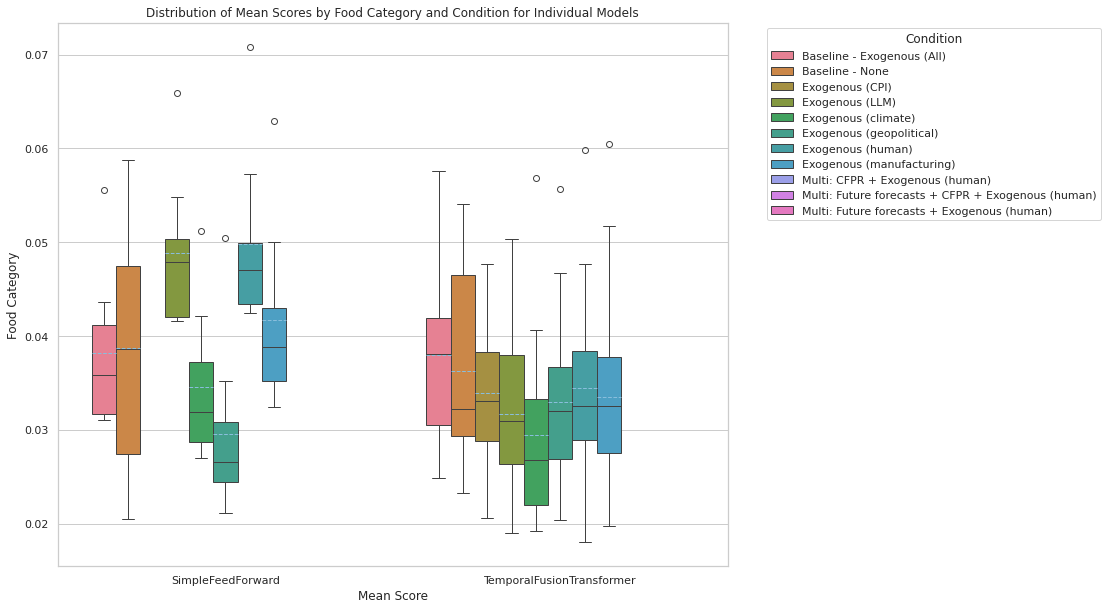

In [16]:

# Set up the plot with category on the y-axis, mean_score on the x-axis, and hue for conditions
plt.figure(figsize=(12, 10))
sns.boxplot(data=filt_df, y='mean_score', x='model_name', hue='condition', showmeans=True, meanline=True)

# Add plot labels and title
plt.title("Distribution of Mean Scores by Food Category and Condition for Individual Models")
plt.xlabel("Mean Score")
plt.ylabel("Food Category")

# Show plot with legend outside
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [17]:
summary_pivot = filt_df.groupby('condition').agg(
    Mean=('mean_score', 'mean'),
    Median=('mean_score', 'median'),
    Std_Dev=('mean_score', 'std'),
    Min=('mean_score', 'min'),
    Max=('mean_score', 'max'),
    Count=('mean_score', 'count')
).reset_index()

# Display the pivot table
summary_pivot

,condition,Mean,Median,Std_Dev,Min,Max,Count
0,Baseline - Exogenous (All),0.038691,0.039762,0.010405,0.020411,0.061410,40
1,Baseline - None,0.038734,0.035369,0.015155,0.017427,0.109889,80
2,Exogenous (CPI),0.033913,0.033077,0.008760,0.020619,0.047740,8
3,Exogenous (LLM),0.037455,0.038011,0.011792,0.018981,0.065877,24
4,Exogenous (climate),0.031170,0.029077,0.009517,0.019200,0.056840,24
5,Exogenous (geopolitical),0.031873,0.030113,0.009366,0.020357,0.055688,24
6,Exogenous (human),0.041834,0.037346,0.018769,0.018108,0.116357,33
7,Exogenous (manufacturing),0.036285,0.035194,0.011044,0.019716,0.062893,24
8,Multi: CFPR + Exogenous (human),0.040064,0.034042,0.016797,0.017961,0.062915,9
9,Multi: Future forecasts + CFPR + Exogenous (hu...,0.046782,0.049071,0.013410,0.022256,0.062542,9


### Multiple models

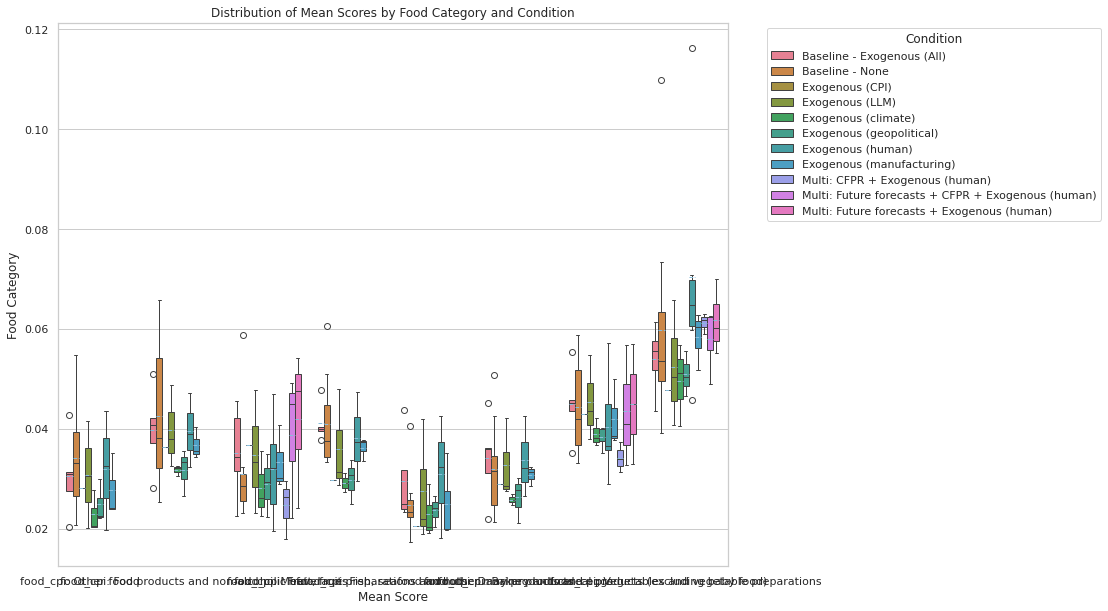

In [18]:

# Set up the plot with category on the y-axis, mean_score on the x-axis, and hue for conditions
plt.figure(figsize=(12, 10))
sns.boxplot(data=filt_df, y='mean_score', x='category', hue='condition', showmeans=True, meanline=True)

# Add plot labels and title
plt.title("Distribution of Mean Scores by Food Category and Condition")
plt.xlabel("Mean Score")
plt.ylabel("Food Category")

# Show plot with legend outside
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [19]:
# Step 1: Aggregate mean and standard deviation
summary_table = filt_df.groupby(['category', 'condition']).agg(
    Mean_Score=('mean_score', 'mean'),
    Std_Deviation=('mean_score', 'std')
).reset_index()

# Step 2: Format the results as "mean ± std"
summary_table['Mean_Std'] = summary_table.apply(
    lambda row: f"{row['Mean_Score']:.3f} ± {row['Std_Deviation']:.3f}", axis=1
)

# Step 3: Pivot the table to have each condition as a column
pivot_table = summary_table.pivot(index='category', columns='condition', values='Mean_Std').reset_index()

# Display the pivoted summary table
pivot_table.set_index('category')

condition,Baseline - Exogenous (All),Baseline - None,Exogenous (CPI),Exogenous (LLM),Exogenous (climate),Exogenous (geopolitical),Exogenous (human),Exogenous (manufacturing),Multi: CFPR + Exogenous (human),Multi: Future forecasts + CFPR + Exogenous (human),Multi: Future forecasts + Exogenous (human)
category,,,,,,,,,,,
food_cpi: Bakery and cereal products (excluding baby food),0.045 ± 0.007,0.044 ± 0.010,0.043 ± nan,0.045 ± 0.009,0.039 ± 0.003,0.038 ± 0.003,0.040 ± 0.010,0.042 ± 0.007,0.034 ± 0.003,0.044 ± 0.012,0.045 ± 0.012
food_cpi: Dairy products and eggs,0.034 ± 0.008,0.032 ± 0.009,0.029 ± nan,0.033 ± 0.008,0.026 ± 0.001,0.026 ± 0.005,0.034 ± 0.008,0.031 ± 0.002,NaN,NaN,NaN
"food_cpi: Fish, seafood and other marine products",0.030 ± 0.009,0.025 ± 0.006,0.021 ± nan,0.028 ± 0.012,0.023 ± 0.005,0.024 ± 0.003,0.031 ± 0.012,0.025 ± 0.009,NaN,NaN,NaN
food_cpi: Food,0.031 ± 0.008,0.034 ± 0.011,0.028 ± nan,0.031 ± 0.011,0.023 ± 0.004,0.025 ± 0.004,0.032 ± 0.012,0.028 ± 0.006,NaN,NaN,NaN
"food_cpi: Fruit, fruit preparations and nuts",0.041 ± 0.004,0.041 ± 0.009,0.030 ± nan,0.036 ± 0.010,0.029 ± 0.002,0.030 ± 0.004,0.038 ± 0.009,0.036 ± 0.002,NaN,NaN,NaN
food_cpi: Meat,0.035 ± 0.009,0.031 ± 0.010,0.037 ± nan,0.035 ± 0.012,0.028 ± 0.007,0.029 ± 0.006,0.032 ± 0.010,0.033 ± 0.006,0.025 ± 0.006,0.039 ± 0.015,0.042 ± 0.016
food_cpi: Other food products and non-alcoholic beverages,0.040 ± 0.008,0.043 ± 0.014,0.036 ± nan,0.040 ± 0.008,0.032 ± 0.001,0.032 ± 0.005,0.040 ± 0.007,0.037 ± 0.003,NaN,NaN,NaN
food_cpi: Vegetables and vegetable preparations,0.054 ± 0.007,0.060 ± 0.020,0.048 ± nan,0.052 ± 0.013,0.050 ± 0.008,0.051 ± 0.005,0.070 ± 0.024,0.058 ± 0.006,0.061 ± 0.002,0.058 ± 0.008,0.062 ± 0.008


In [20]:
#Add an overall column 
# Step 1: Format the results as "mean ± std"
summary_pivot['Mean_Std'] = summary_pivot.apply(
    lambda row: f"{row['Mean']:.3f} ± {row['Std_Dev']:.3f}", axis=1)


overall_row = summary_pivot.set_index('condition')['Mean_Std'].T
overall_row

# Step 2: Convert the transposed row to a DataFrame and add 'Overall' label for the category
overall_row = pd.DataFrame(overall_row).T
overall_row['category'] = 'Overall'

#Append 'Overall' row to pivot_table
pivot_table = pd.concat([pivot_table, overall_row], ignore_index=True)

pivot_table.set_index('category')


condition,Baseline - Exogenous (All),Baseline - None,Exogenous (CPI),Exogenous (LLM),Exogenous (climate),Exogenous (geopolitical),Exogenous (human),Exogenous (manufacturing),Multi: CFPR + Exogenous (human),Multi: Future forecasts + CFPR + Exogenous (human),Multi: Future forecasts + Exogenous (human)
category,,,,,,,,,,,
food_cpi: Bakery and cereal products (excluding baby food),0.045 ± 0.007,0.044 ± 0.010,0.043 ± nan,0.045 ± 0.009,0.039 ± 0.003,0.038 ± 0.003,0.040 ± 0.010,0.042 ± 0.007,0.034 ± 0.003,0.044 ± 0.012,0.045 ± 0.012
food_cpi: Dairy products and eggs,0.034 ± 0.008,0.032 ± 0.009,0.029 ± nan,0.033 ± 0.008,0.026 ± 0.001,0.026 ± 0.005,0.034 ± 0.008,0.031 ± 0.002,NaN,NaN,NaN
"food_cpi: Fish, seafood and other marine products",0.030 ± 0.009,0.025 ± 0.006,0.021 ± nan,0.028 ± 0.012,0.023 ± 0.005,0.024 ± 0.003,0.031 ± 0.012,0.025 ± 0.009,NaN,NaN,NaN
food_cpi: Food,0.031 ± 0.008,0.034 ± 0.011,0.028 ± nan,0.031 ± 0.011,0.023 ± 0.004,0.025 ± 0.004,0.032 ± 0.012,0.028 ± 0.006,NaN,NaN,NaN
"food_cpi: Fruit, fruit preparations and nuts",0.041 ± 0.004,0.041 ± 0.009,0.030 ± nan,0.036 ± 0.010,0.029 ± 0.002,0.030 ± 0.004,0.038 ± 0.009,0.036 ± 0.002,NaN,NaN,NaN
food_cpi: Meat,0.035 ± 0.009,0.031 ± 0.010,0.037 ± nan,0.035 ± 0.012,0.028 ± 0.007,0.029 ± 0.006,0.032 ± 0.010,0.033 ± 0.006,0.025 ± 0.006,0.039 ± 0.015,0.042 ± 0.016
food_cpi: Other food products and non-alcoholic beverages,0.040 ± 0.008,0.043 ± 0.014,0.036 ± nan,0.040 ± 0.008,0.032 ± 0.001,0.032 ± 0.005,0.040 ± 0.007,0.037 ± 0.003,NaN,NaN,NaN
food_cpi: Vegetables and vegetable preparations,0.054 ± 0.007,0.060 ± 0.020,0.048 ± nan,0.052 ± 0.013,0.050 ± 0.008,0.051 ± 0.005,0.070 ± 0.024,0.058 ± 0.006,0.061 ± 0.002,0.058 ± 0.008,0.062 ± 0.008
Overall,0.039 ± 0.010,0.039 ± 0.015,0.034 ± 0.009,0.037 ± 0.012,0.031 ± 0.010,0.032 ± 0.009,0.042 ± 0.019,0.036 ± 0.011,0.040 ± 0.017,0.047 ± 0.013,0.050 ± 0.014


### Single model - TemporalFusionTransformer

In [21]:
'''
Here there are:
-no standard deviations for none b/c 
-standard deviations for regressors are mix of w/ covariates 
'''



# Step 1: Aggregate mean and standard deviation
summary_table = filt_df.groupby(['category', 'condition']).agg(
    Mean_Score=('mean_score', 'mean'),
    Std_Deviation=('mean_score', 'std')
).reset_index()

# Step 2: Format the results as "mean ± std"
summary_table['Mean_Std'] = summary_table.apply(
    lambda row: f"{row['Mean_Score']:.4f} ± {row['Std_Deviation']:.4f}", axis=1
)


# Step 3: Pivot the table to have each condition as a column
pivot_table = summary_table.pivot(index='category', columns='condition', values='Mean_Std').reset_index()

# Display the pivoted table
pivot_table

condition,category,Baseline - Exogenous (All),Baseline - None,Exogenous (CPI),Exogenous (LLM),Exogenous (climate),Exogenous (geopolitical),Exogenous (human),Exogenous (manufacturing),Multi: CFPR + Exogenous (human),Multi: Future forecasts + CFPR + Exogenous (human),Multi: Future forecasts + Exogenous (human)
0,food_cpi: Bakery and cereal products (excludin...,0.0451 ± 0.0072,0.0443 ± 0.0096,0.0429 ± nan,0.0455 ± 0.0086,0.0390 ± 0.0028,0.0384 ± 0.0028,0.0404 ± 0.0102,0.0421 ± 0.0069,0.0342 ± 0.0031,0.0435 ± 0.0122,0.0450 ± 0.0120
1,food_cpi: Dairy products and eggs,0.0341 ± 0.0084,0.0320 ± 0.0093,0.0290 ± nan,0.0327 ± 0.0081,0.0259 ± 0.0011,0.0264 ± 0.0047,0.0338 ± 0.0081,0.0308 ± 0.0019,NaN,NaN,NaN
2,"food_cpi: Fish, seafood and other marine products",0.0296 ± 0.0086,0.0249 ± 0.0062,0.0206 ± nan,0.0276 ± 0.0125,0.0229 ± 0.0054,0.0237 ± 0.0031,0.0310 ± 0.0123,0.0250 ± 0.0088,NaN,NaN,NaN
3,food_cpi: Food,0.0306 ± 0.0081,0.0341 ± 0.0105,0.0281 ± nan,0.0308 ± 0.0107,0.0229 ± 0.0042,0.0249 ± 0.0044,0.0320 ± 0.0119,0.0278 ± 0.0065,NaN,NaN,NaN
4,"food_cpi: Fruit, fruit preparations and nuts",0.0411 ± 0.0039,0.0411 ± 0.0090,0.0298 ± nan,0.0360 ± 0.0104,0.0292 ± 0.0019,0.0299 ± 0.0045,0.0382 ± 0.0089,0.0363 ± 0.0023,NaN,NaN,NaN
5,food_cpi: Meat,0.0352 ± 0.0091,0.0311 ± 0.0102,0.0368 ± nan,0.0348 ± 0.0124,0.0281 ± 0.0067,0.0290 ± 0.0063,0.0320 ± 0.0100,0.0333 ± 0.0065,0.0247 ± 0.0061,0.0388 ± 0.0145,0.0421 ± 0.0158
6,food_cpi: Other food products and non-alcoholi...,0.0399 ± 0.0083,0.0426 ± 0.0139,0.0363 ± nan,0.0398 ± 0.0083,0.0318 ± 0.0010,0.0318 ± 0.0047,0.0396 ± 0.0074,0.0367 ± 0.0032,NaN,NaN,NaN
7,food_cpi: Vegetables and vegetable preparations,0.0540 ± 0.0068,0.0599 ± 0.0201,0.0477 ± nan,0.0524 ± 0.0126,0.0496 ± 0.0082,0.0509 ± 0.0045,0.0704 ± 0.0241,0.0584 ± 0.0058,0.0613 ± 0.0020,0.0580 ± 0.0077,0.0617 ± 0.0075


In [22]:
'''
Here there are:
-no standard deviations for none b/c 
-standard deviations for regressors are mix of w/ covariates 
'''

# Step 2: Format the results as "mean ± std"
filt_df['Mean_Std'] = filt_df.apply(
    lambda row: f"{row['mean_score']:.3f} ± {row['std_score']:.3f}", axis=1
)


# Step 3: Pivot the table to have each condition as a column
pivot_table = filt_df.pivot(index='category', columns='condition', values='Mean_Std').reset_index()

# Display the pivoted table
pivot_table

ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
# Step 1: Format the results as "mean ± std"
summary_pivot['Mean_Std'] = summary_pivot.apply(
    lambda row: f"{row['Mean']:.3f} ± {row['Std_Dev']:.3f}", axis=1)


overall_row = summary_pivot.set_index('condition')['Mean_Std'].T
overall_row

# Step 2: Convert the transposed row to a DataFrame and add 'Overall' label for the category
overall_row = pd.DataFrame(overall_row).T
overall_row['category'] = 'Overall'

#Append 'Overall' row to pivot_table
pivot_table = pd.concat([pivot_table, overall_row], ignore_index=True)

pivot_table.set_index('category')


In [ ]:

# # Step 1: Create a bar plot with error bars to reflect std deviation
# plt.figure(figsize=(12, 8))
# sns.barplot(data=filt_df, x='category', y='mean_score', hue='condition', ci=None)

# # Step 2: Add error bars manually for std deviation
# for index, row in filt_df.iterrows():
#     category_index = filt_df['category'].tolist().index(row['category'])
#     condition_offset = {'all': -0.3, 'climate': -0.15, 'geopolitical': 0, 'manufacturing': 0.15, 'none': 0.3}  # Offset to separate conditions
#     plt.errorbar(
#         x=category_index + condition_offset[row['condition']], 
#         y=row['mean_score'],
#         yerr=row['std_score'],
#         fmt='none',  # No plot marker, only error bars
#         color='black',  # Error bar color
#         capsize=5  # Cap width
#     )

# # Customize plot labels and legend
# plt.title("Mean Scores by Food Category with Standard Deviation as Error Bars")
# plt.xlabel("Food Category")
# plt.ylabel("Mean Score")
# plt.xticks(rotation=45)
# plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')

# # Show plot
# plt.show()